In [1]:
import os
GPU_id = 1
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import sys
sys.path.insert(1, '../')

In [3]:
import torch
import pandas as pd
import numpy as np
from time import time 
# from ds_itr.adamw import AdamW as AW

import fastai
from fastai import *
from fastai.basic_data import *
from fastai.basic_data import *
from fastai.tabular import *
from fastai.basic_data import DataBunch
from fastai.tabular import TabularModel

import cudf

from ds_itr.preproc import Preprocessor
from ds_itr.ops import Normalize, FillMissing, Categorify, Moments, Median, Encoder
from ds_itr.dl_encoder import DLLabelEncoder
from ds_itr.ds_iterator import GPUDatasetIterator
from ds_itr.batchloader import FileItrDataset, DLCollator, DLDataLoader, TensorItrDataset
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


In [4]:
torch.__version__, cudf.__version__, fastai.__version__

('1.4.0.dev20191119', '0.11.0a+3127.gd8677c49a.dirty', '1.0.59')

In [5]:
%load_ext snakeviz
# load snakeviz if you want to run profiling

In [6]:
# to_cpu = True

In [7]:
import datetime
datafolder = '/datasets/rossmann/'


In [8]:
traindf = pd.read_csv(f'{datafolder}/train.csv', low_memory=False)
testdf = pd.read_csv(f'{datafolder}/test.csv', low_memory=False)
storedf = pd.read_csv(f'{datafolder}/store.csv', low_memory=False)
print("Preprocessing...")

categorical_cols = [
    'Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'Week', 'Promo', 'StateHoliday', 'SchoolHoliday',
    'StoreType', 'Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
    'Promo2SinceYear', 'PromoInterval',
]
continuous_cols = [
    'CompetitionDistance'
]
traindf = traindf.drop(['Customers', 'Open'], axis=1)
testdf = testdf.drop(['Open', 'Id'], axis=1)

def modify_df(df):
    initlen = len(df)

    # Expand date into [Year, Month, Day, Week]
    df.Date = pd.to_datetime(df.Date)
    for attr in ['Year', 'Month', 'Day', 'Week']:
        df[attr] = getattr(pd.DatetimeIndex(df.Date), attr.lower())

    # Join store.csv and train/test.csv on Store
    df = pd.merge(df, storedf, on='Store')

    # Fix NaNs in *Since* columns
    defaults = {'CompetitionOpenSinceYear': 1900, 'CompetitionOpenSinceMonth': 1,
                'Promo2SinceYear': 1900, 'Promo2SinceWeek': 1, 'CompetitionDistance': 0}
    df = df.fillna(defaults)

    # Ensure no rows lost on the join
    assert len(df) == initlen

    # Cast continuous columns to float
    df = df.astype({x: 'float32' for x in continuous_cols})

    # StateHoliday is a special case
    df.StateHoliday = df.StateHoliday.astype(str).replace("0", "d")

    # Move the continuous columns to the end
    for column in continuous_cols:
        cd = df.pop(column)
        df[column] = cd
    return df

traindf = modify_df(traindf)
testdf = modify_df(testdf)

# Filter out 0 sales from train
traindf = traindf[traindf.Sales > 0]

# Index categorical columns across both train and test.
for col in categorical_cols:
    # Get the default type for the column
    default_type = traindf[col].dtype.type() if traindf[col].dtype.type() is not None else ''
    # Fix NaNs with the default value for the column's type.
    traindf[col] = traindf[col].fillna(default_type)
    testdf[col] = testdf[col].fillna(default_type)

# Move the sales column to the end
sales = traindf.pop('Sales')
traindf['Sales'] = sales

# Make a validation set from the equivalent period of the test set in the training set, a year before.
t0 = testdf.Date.min() - datetime.timedelta(365)
t1 = testdf.Date.max() - datetime.timedelta(365)
val_mask = (traindf.Date > t0) & (traindf.Date <= t1)
valdf, traindf = traindf[val_mask], traindf[~val_mask]

# Drop unnecessary columns
traindf = traindf.drop('Date', axis=1)
valdf = valdf.drop('Date', axis=1)
testdf = testdf.drop('Date', axis=1)

print("Saving to file...")
traindf.to_csv(f'{datafolder}/train_fin.csv', index=False)
testdf.to_csv(f'{datafolder}/test_fin.csv', index=False)
valdf.to_csv(f'{datafolder}/val_fin.csv', index=False)

print("Done.")

Preprocessing...
Saving to file...
Done.


In [9]:
# traindf.describe()

<h3> Dataset Gathering: Define files in the training and validation datasets. </h3>

In [10]:
train_set = [datafolder + 'train_fin.csv']
valid_set = [datafolder + 'val_fin.csv']

In [11]:
cols = list(traindf.columns)

<h4>Grab column information</h4>

In [12]:
cat_names = [
        'Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'Week', 'Promo', 'StateHoliday', 'SchoolHoliday',
        'StoreType', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Assortment',
        'Promo2SinceYear', 'PromoInterval',
    ]
cont_names = [
        'CompetitionDistance'
    ] 
cat_names = [name for name in cat_names if name in cols]
cont_names = [name for name in cont_names if name in cols]


<h3>Preprocessing:</h3> <p>Select operations to perform, create the Preprocessor object, create dataset iterator object and collect the stats on the training dataset</p>

In [13]:
%%time
a,b,c = Normalize(), FillMissing(), Categorify()
procs = [c]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15.7 µs


In [14]:
%time
stat_ops = [Moments(), Median(), Encoder()]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs


In [ ]:
feat_ops = [LogOp(), Export()]

In [15]:
%%time
proc = Preprocessor(cat_names=cat_names, cont_names=cont_names, label_name=['Sales'], stat_ops=stat_ops, df_ops=procs, to_cpu=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 108 µs


In [16]:
%%time
trains_itrs = GPUDatasetIterator(train_set,names=cols, engine='csv')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 31.9 µs


In [17]:
%%time
proc.update_stats(trains_itrs)

CPU times: user 2.36 s, sys: 1.77 s, total: 4.14 s
Wall time: 4.25 s


<h5>Gather embeddings using statistics gathered in the Read phase.</h5>

In [18]:
embeds = c.get_emb_sz(proc.stats["encoders"], proc.cat_names)
embeddings = [x[1] for x in embeds]
embeddings, embeds

([(4, 3),
  (13, 7),
  (24, 9),
  (32, 11),
  (8, 5),
  (13, 7),
  (3, 3),
  (3, 3),
  (25, 10),
  (9, 5),
  (5, 4),
  (3, 3),
  (5, 4),
  (1116, 16),
  (5, 4),
  (53, 15),
  (4, 3)],
 [('Assortment', (4, 3)),
  ('CompetitionOpenSinceMonth', (13, 7)),
  ('CompetitionOpenSinceYear', (24, 9)),
  ('Day', (32, 11)),
  ('DayOfWeek', (8, 5)),
  ('Month', (13, 7)),
  ('Promo', (3, 3)),
  ('Promo2', (3, 3)),
  ('Promo2SinceWeek', (25, 10)),
  ('Promo2SinceYear', (9, 5)),
  ('PromoInterval', (5, 4)),
  ('SchoolHoliday', (3, 3)),
  ('StateHoliday', (5, 4)),
  ('Store', (1116, 16)),
  ('StoreType', (5, 4)),
  ('Week', (53, 15)),
  ('Year', (4, 3))])

In [19]:
valids_itr = GPUDatasetIterator(valid_set,names=cols, engine='csv')

<h5>Create the file iterators using the FileItrDataset Class.</h5>

In [20]:
train_xy = proc.ds_to_tensors(trains_itrs)
val_xy = proc.ds_to_tensors(valids_itr)


In [21]:
%%time
t_sets = [train_xy[0], train_xy[1], train_xy[2]]
v_sets = [val_xy[0], val_xy[1], val_xy[2]]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


In [22]:
t_batch_sets = [TensorItrDataset(t_sets, batch_size=1024) for i in range(10)]
v_batch_sets = [TensorItrDataset(v_sets, batch_size=1024) for i in range(10)]

In [23]:
%%time
t_chain = torch.utils.data.ChainDataset(t_batch_sets)
v_chain = torch.utils.data.ChainDataset(v_batch_sets)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 31.2 µs


<h5>Use the Deep Learning Collator to create a collate function to pass to the dataloader.</h5>

In [25]:
def gen_col(batch):
    batch = batch[0]
    return batch[0], batch[1].long()

In [26]:
%%time
t_data = DLDataLoader(t_chain, collate_fn=gen_col, pin_memory=False, num_workers=8)
v_data = DLDataLoader(v_chain, collate_fn=gen_col, pin_memory=False, num_workers=8)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 120 µs


<h4>After creating the Dataloaders you can leverage fastai framework to create Machine Learning models</h4>

In [27]:
databunch = DataBunch(t_data, v_data, collate_fn=gen_col, device="cuda")

In [28]:
%%time

model = TabularModel(emb_szs = embeddings, n_cont=len(cont_names), out_sz=1, layers=[1000, 1000, 1000, 500], y_range=[0,49861.2])

learn =  Learner(databunch, model)
learn.loss_func = MSELossFlat()
# learn.opt_func = AW
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 1.86 s, sys: 884 ms, total: 2.74 s
Wall time: 2.99 s


Min numerical gradient: 1.91E-02
Min loss divided by 10: 3.31E-01


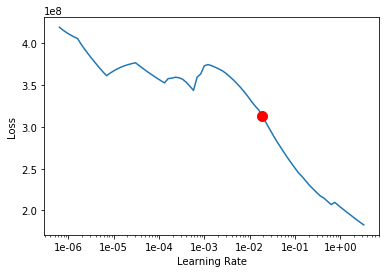

In [29]:
learn.recorder.plot(show_moms=True, suggestion=True)

In [30]:
learning_rate = 2.75-2
epochs = 10
from fastai.utils.mod_display import *

In [31]:
start = time()
learn.fit(epochs,learning_rate)
t_final = time() - start 

epoch,train_loss,valid_loss,time
0,86455552.000000,54645956.000000,02:24
1,62970988.000000,295672576.000000,02:25
2,64557100.000000,56079480.000000,02:23
3,72190992.000000,79469320.000000,02:21
4,64439548.000000,675322368.000000,02:25
5,66590396.000000,55221592.000000,02:24
6,62597164.000000,229323856.000000,02:25
7,63081116.000000,96786160.000000,02:25
8,63591808.000000,54668464.000000,02:25
9,66510692.000000,54452020.000000,02:25


 
*** Profile stats marshalled to file '/tmp/tmp0q9l2t9x'. 
Embedding SnakeViz in this document...


In [32]:
del learn 
del model
del databunch
torch.cuda.empty_cache() 

In [33]:
t_final

1447.0645787715912